In [20]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys
import time

if "../" not in sys.path:
  sys.path.append("../") 

from collections import defaultdict
from lib.envs.cliff_walking import CliffWalkingEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [21]:
env = CliffWalkingEnv()

In [22]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [23]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Lambda time discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # Implement this!
        state = env.reset()
        while True:
            action = np.random.choice(np.arange(env.nA), p = policy(state))
            next_state, reward, done, _ = env.step(action)
            
            max_reward = max([Q[next_state][next_action] for next_action in range(env.nA)])
            
            td_target = reward + discount_factor*max_reward
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
            
            state = next_state
            stats.episode_lengths[i_episode] += 1
            stats.episode_rewards[i_episode] += reward
            
            if done:
                break;
        
    
    return Q, stats

In [24]:
start = time.time()
Q, stats = q_learning(env, 2500, alpha = 0.5)
end = time.time()
print (" Time cost: %s s" % str(end-start))

Episode 2500/2500. Time cost: 4.863486289978027 s


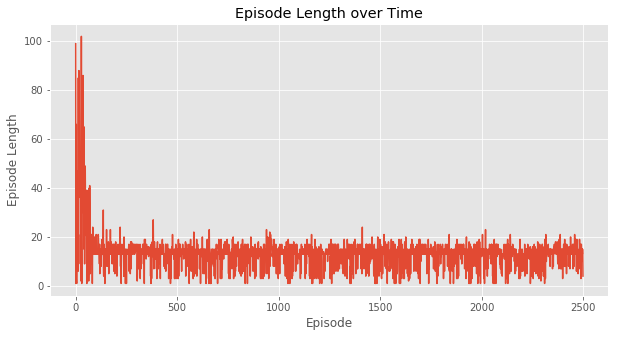

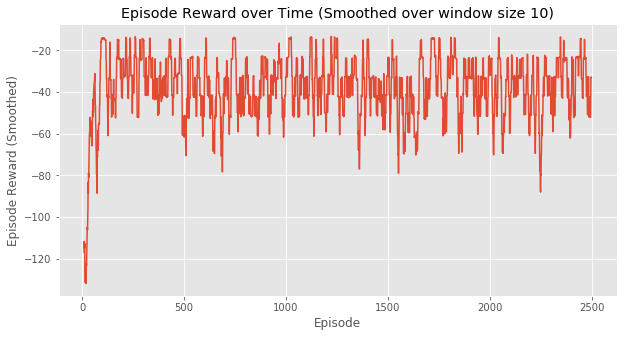

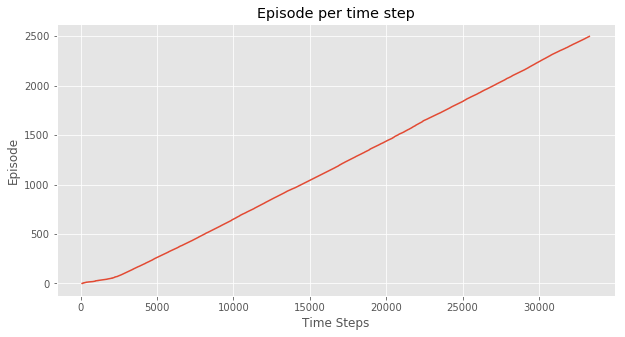

(<matplotlib.figure.Figure at 0xcee0518>,
 <matplotlib.figure.Figure at 0xd0f17f0>)

In [25]:
plotting.plot_episode_stats(stats)

In [26]:
def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Lambda time discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # 使用当前policy，生成样本
        state = env.reset()
        action = np.random.choice(np.arange(env.nA), p=policy(state))
        while True:
            next_state, reward, done, _ = env.step(action)
            next_action = np.random.choice(np.arange(env.nA), p=policy(next_state))
            
            # 更新Q,由于policy有Q的引用，所以也就隐式的更新了
            td_target = reward + discount_factor * Q[next_state][next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
            
            # 更新算法状态
            state = next_state
            action = next_action
            
            # 更新统计状态
            stats.episode_lengths[i_episode] += 1
            stats.episode_rewards[i_episode] += reward
            
            if done:
                break
    
    return Q, stats

In [27]:
start = time.time()
Q, stats = sarsa(env, 2500)
end = time.time()
print (" Time cost: %s s" % str(end-start))

Episode 2500/2500. Time cost: 12.109210968017578 s


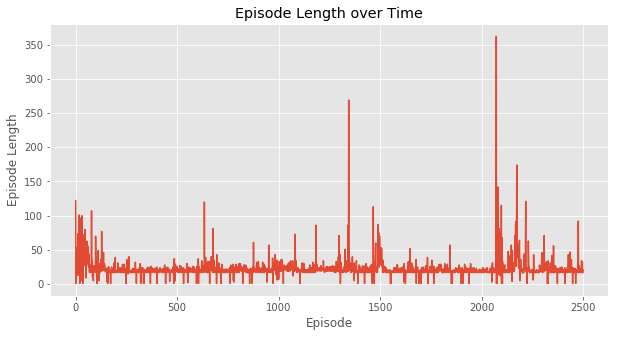

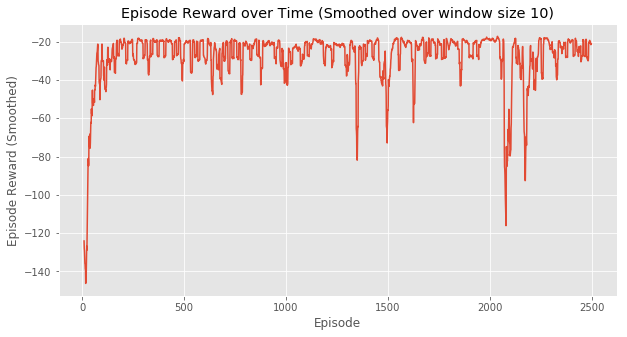

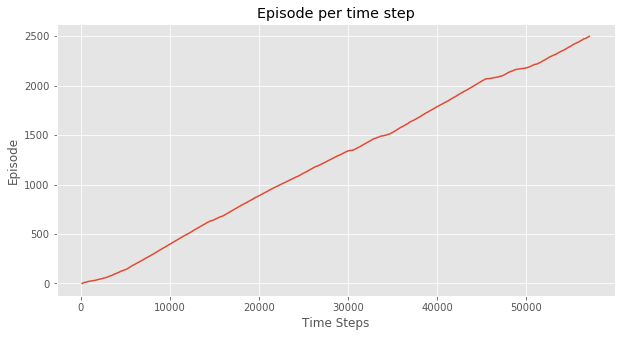

(<matplotlib.figure.Figure at 0xd0ffe10>,
 <matplotlib.figure.Figure at 0xd24ecf8>)

In [28]:
plotting.plot_episode_stats(stats)